<a class="anchor" id="top"></a>

# Modeling Risk Classification
Author: Ainesh Pandey

In this notebook, we will train and tune several different multi-class modeling approaches to categorize projects into one of the risk classifications generated in the [GenerateRiskTarget notebook](GenerateRiskTarget.ipynb). As a quick reminder, the risk classifications generated are as follows:
- `Risk Class 0`: Technical Execution Risk
- `Risk Class 1`: Managerial Process Risk
- `Risk Class 2`: Operational Cost Risk

## Table of Contents
[Step 1: Import Packages and Data](#step-1) <br>
[Step 2: Helper Functions for Modeling](#step-2) <br>
[Step 3: Prototyping Baseline Solution](#step-3) <br>
[Step 4: Testing Augmented Inputs](#step-4) <br>
[Step 5: Results and Saving Models to Project](#step-5) <br>

<a class="anchor" id="step-1"></a>

## Import Packages and Data

### Packages

We start by importing the required packages for this analysis.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# basic data science packages
import pandas as pd
import numpy as np

# sklearn packages for data preparation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# imblearn packages for handling unbalanced data
from imblearn.under_sampling import OneSidedSelection

# modeling packages
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import itertools

# visualization packages
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# package to save models to project
import pickle

# import custom preprocessing functions that we wrote in utils.py
from scripts.utils import preprocess_string_pro, preprocess_string_aug

### Data
We import `lessons_learned.csv` and keep all of the data. After some exploratory data analysis, we'll choose which features we will keep as inputs.

In [2]:
df_lessons = pd.read_csv('../Risky Space Business Challenge Files/lessons_learned.csv', encoding='cp1252')

display(df_lessons.shape)
df_lessons.head()

(2101, 17)

,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat..."
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,..."
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate..."
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S..."
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M..."


Next, we will import `risk_classifications.csv`, which we created in [GenerateRiskTarget.ipynb](GenerateRiskTarget.ipynb).

In [3]:
df_riskclasses = pd.read_csv('../data/risk_classifications.csv')

display(df_riskclasses.shape)
df_riskclasses.head()

(2066, 2)

,Lesson ID,Risk Class
0,1308,2
1,616,0
2,1307,2
3,304,2
4,437,0


We will combine both dataframes into a master dataframe.

In [4]:
df_master = df_lessons.merge(df_riskclasses, on='Lesson ID', how='inner')

display(df_master.shape)
df_master.head()

(2066, 18)

,Lesson ID,Title,Abstract,Lesson(s) Learned,Recommendation(s),Organization,Date Lesson Occurred,Driving Event,Evidence,Project / Program,"The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules",NASA Mission Directorate(s),Sensitivity,From what phase of the program or project was this lesson learned captured?,"Where (other lessons, presentations, publications, etc.)?",Publish Date,Topics,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,Approach 1 made it difficult to understand the...,Projects should consider RBI's risk management...,LaRC,04/05/2018,"Throughout the project, it was repeatedly dete...",NaN,Radiation Budget Instrument,Langley Management System Center Procedure LMS...,"Aeronautics Research, Human Exploration and Op...",Public,Implementation,LaRC Institutional Knowledge Management (IKM) ...,07/23/2021,"Procurement, Small Business & Industrial Relat...",1
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,As a result of many years of expensive lessons...,As commercial vehicles and other NASA vehicles...,NESC,02/28/2021,NASA has found that the commercial spacecraft ...,NaN,"Space Shuttle Program, Commercial Crewed Space...",NaN,Human Exploration and Operations,Public,Implementation » Phase E,NaN,07/23/2021,"Flight Equipment, Ground Operations, Hardware,...",0
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,There was an unexpectedly wide variation in el...,The recommendations to prevent this lesson fro...,NESC,12/14/2020,"Hypergolic propellants (e.g., hydrazine (N2H4)...",NaN,All NASA missions using high purity hydrazine ...,NaN,"Human Exploration and Operations, Science, Spa...",Public,Not Applicable,NaN,06/23/2021,"Ground Operations, Launch Vehicle, Parts, Mate...",1
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,"If possible, the design phase of both systems ...",Design phase should incorporate both design te...,KSC,03/15/2020,The RADCC AV system controls and routes variou...,NaN,Radiological Control Center (RADCC),NPR 7120.7A NASA Information Technology Progra...,Human Exploration and Operations,Public,Not Specified,NaN,06/01/2021,"Engineering Design, Integration and Testing, S...",2
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,The pinch was initially visually inspected and...,Have pinch tool operator perform several pract...,KSC,10/17/2020,A copper tube was pinched as a test for the Ma...,Inverted metallography image of separated pinc...,Mass Spectrometer observing lunar operations (...,NaN,"Human Exploration and Operations, Space Techno...",Public,Implementation » Phase D,NaN,12/10/2020,"Engineering Design, Integration and Testing, M...",2


[Back to Top](#top)

<a class="anchor" id="step-2"></a>

## Helper Functions for Data Prep and Modeling

There are many repetitive steps during data prep and modeling. Here, we will define helper functions to carry out those tasks.

### Data Preparation Helper Functions

#### create_pca_representation()

We start with the `create_pca_representation()` function, which will take our preprocessed descriptions, convert them into TF-IDF vectors, and then convert them using PCA into the format needed for further analysis. This function will also return the vectorizers used for both TF-IDF and PCA.

In [5]:
def create_pca_representation(description_col, type):
    if type=='prototype':
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess_string_pro,
                                           stop_words = 'english', strip_accents='unicode', lowercase=True)
    elif type=='augmented':
        tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1, 2), min_df = 5, max_df=0.5, preprocessor=preprocess_string_aug,
                                           stop_words = 'english', strip_accents='unicode', lowercase=True)
    pca_vectorizer = PCA(n_components=100, random_state=5)

    tfidf_matrix = tfidf_vectorizer.fit_transform(description_col)
    tfidf_df     = pd.DataFrame(tfidf_matrix.todense())
    pca_matrix   = pca_vectorizer.fit_transform(tfidf_df)

    return pca_matrix, tfidf_vectorizer, pca_vectorizer

#### split_data()

Next, we will write the `split_data()` function, which will use __imblearn__ package's `OneSidedSelection()` function and __sklearn__ package's `train_test_split()` function to split the data into a training set and a testing set.

In [6]:
def split_data(df):
    X = df.drop(['Lesson ID', 'Risk Class'], axis=1)
    y = df['Risk Class']

    X, y = OneSidedSelection(random_state=5).fit_resample(X, y)
    return train_test_split(X, y, test_size=0.10, stratify=y, random_state=5)

### Modeling Helper Functions

#### custom scorer

Our model tuning will be based on the F1-score metric. However, because our problem is multi-class, we need to specify the _average_ parameter.

In [7]:
scorer = make_scorer(f1_score, average = 'weighted')

#### model_logisticregression_tuned()

The first model we will try to run is a standard `LogisticRegression` model, tuned for the following parameters:
- *solver*: the algorithm to use in the optimization problem
- *penalty*: the norm of the penalty
- *C*: regularization term

In [8]:
def model_logisticregression_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'solver': ['newton-cg', 'lbfgs'],
        'penalty': ['none', 'l2'],
        'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_lm = GridSearchCV(estimator=LogisticRegression(class_weight='balanced', random_state=5),
                         scoring=scorer, param_grid=param_grid, n_jobs=-1, verbose=0).fit(X_train, y_train)

    # print(CV_lm.cv_results_['mean_test_score'])

    # extract the best parameters, as selected by the grid search
    best_params = CV_lm.best_params_
    best_solver = best_params['solver']
    best_penalty = best_params['penalty']
    best_C = best_params['C']
    print(best_params)

    # create the final LogisticRegression
    best_lm = LogisticRegression(class_weight='balanced', random_state=5,
                                solver=best_solver,
                                penalty=best_penalty,
                                C=best_C).fit(X_train, y_train)
    lm_pred = best_lm.predict(X_test)

    # track other related model performance metrics
    lm_metrics = classification_report(y_test, lm_pred, digits=3)
    
    # return the model and the confusion matrix
    return best_lm, lm_metrics

#### model_randomforestclassifier_tuned()

The next model we will try to run is a `RandomForestClassifier` model, tuned for the following parameters:
- *n_estimators*: the number of trees in the forest
- *max_features*: the number of features to consider when looking for the best split
- *max_depth*: the maximum depth of each tree
- *criterion*: the function to measure the quality of a split

In [9]:
def model_randomforestclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = { 
        'n_estimators': range(100, 400, 100),
        'max_features': ['auto', 'log2', 0.25, 0.33, 0.5],
        'max_depth' : [None, 5, 8],
        'criterion' : ['gini', 'entropy']
    }

    # get balanced sample weights
    sample = class_weight.compute_sample_weight('balanced', y_train)

    # run the cross-validated grid search to identify the best parameters for the model
    CV_rfc = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train, sample_weight=sample)

    # extract the best parameters, as selected by the grid search
    best_params = CV_rfc.best_params_
    best_n_estimators = best_params['n_estimators']
    best_max_features = best_params['max_features']
    best_max_depth = best_params['max_depth']
    best_criterion = best_params['criterion']
    print(best_params)

    # create the final RandomForestClassifier
    best_rfc = RandomForestClassifier(class_weight='balanced', random_state=5,
                                    max_features=best_max_features,
                                    n_estimators=best_n_estimators,
                                    max_depth=best_max_depth,
                                    criterion=best_criterion).fit(X_train, y_train, sample_weight=sample)
    rfc_pred = best_rfc.predict(X_test)

    # track other related model performance metrics
    rfc_metrics = classification_report(y_test, rfc_pred, digits=3)

    # return the model and the confusion matrix
    return best_rfc, rfc_metrics

#### model_lgbmclassifier_tuned()

The next model we will try to run is a `LGBMClassifier` model, tuned for the following parameters:
- *max_depth*: maximum tree depth for base learners, <=0 means no limit
- *num_leaves*: maximum tree leaves for base learners
- *reg_alpha*: L1 regularization term on weights
- *reg_lambda*: L2 regularization term on weights
- *min_split_gain*: minimum loss reduction required to make a further partition on a leaf node of the tree

In [10]:
def model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'max_depth': [15, 20, -1],
        'num_leaves': [10, 20, 30],
        'reg_alpha': [0, 0.5, 1.0],
        'reg_lambda': [0, 0.5, 1.0],
        'min_split_gain': [0, 0.2, 0.4]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_lgb = GridSearchCV(estimator=LGBMClassifier(class_weight='balanced', random_state=5), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_lgb.best_params_
    best_max_depth = best_params['max_depth']
    best_num_leaves = best_params['num_leaves']
    best_reg_alpha = best_params['reg_alpha']
    best_reg_lambda = best_params['reg_lambda']
    best_min_split_gain = best_params['min_split_gain']
    print(best_params)

    # create the final LGBMClassifier
    best_lgb = LGBMClassifier(class_weight='balanced', random_state=5,
                            max_depth=best_max_depth,
                            num_leaves=best_num_leaves,
                            reg_alpha=best_reg_alpha,
                            reg_lambda=best_reg_lambda,
                            min_split_gain=best_min_split_gain).fit(X_train, y_train)
    lgb_pred = best_lgb.predict(X_test)

    # track other related model performance metrics
    lgb_metrics = classification_report(y_test, lgb_pred, digits=3)

    # return the model and the confusion matrix
    return best_lgb, lgb_metrics

#### model_knnclassifier_tuned()

The next model we will try to run is a `KNeighborsClassifier` model, tuned for the following parameters:
- *n_neighbors*: number of neighbors
- *weights*: weight function used in prediction
- *algorithm*: algorithm used to compute the nearest neighbors
- *p*: power parameter for the Minkowski metric (1=L1, 2=L2, 3=L_3 for Minkowski)

In [11]:
def model_knnclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'n_neighbors': [1, 3, 5],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'p': [1, 2, 3]
    }

    # run the cross-validated grid search to identify the best parameters for the model
    CV_knn = GridSearchCV(estimator=KNeighborsClassifier(), scoring=scorer,
                        param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train)

    # extract the best parameters, as selected by the grid search
    best_params = CV_knn.best_params_
    best_n_neighbors = best_params['n_neighbors']
    best_weights = best_params['weights']
    best_algorithm = best_params['algorithm']
    best_p = best_params['p']
    print(best_params)

    # create the final KNeighborsClassifier
    best_knn = KNeighborsClassifier(n_neighbors=best_n_neighbors,
                            weights=best_weights,
                            algorithm=best_algorithm,
                            p=best_p).fit(X_train, y_train)
    knn_pred = best_knn.predict(X_test)

    # track other related model performance metrics
    knn_metrics = classification_report(y_test, knn_pred, digits=3)

    # return the model and the confusion matrix
    return best_knn, knn_metrics

#### model_gnbclassifier_tuned()

The final model we will try to run is a `GaussianNB` model, tuned for the following parameters:
- *var_smoothing*: portion of the largest variance of all features that is added to variances for calculation stability

In [12]:
from sklearn.utils import class_weight

def model_gnbclassifier_tuned(X_train, y_train, X_test, y_test):
    # create parameter grid to fine-tune model
    param_grid = {
        'var_smoothing': np.logspace(0,-9, num=20)
    }

    # get balanced sample weights
    sample = class_weight.compute_sample_weight('balanced', y_train)

    # run the cross-validated grid search to identify the best parameters for the model
    CV_gnb = GridSearchCV(estimator=GaussianNB(), scoring=scorer,
                          param_grid=param_grid, n_jobs=-1, verbose=2).fit(X_train, y_train, sample_weight=sample)

    # extract the best parameters, as selected by the grid search
    best_params = CV_gnb.best_params_
    best_var_smoothing = best_params['var_smoothing']
    print(best_params)

    # create the final GaussianNB classifier
    best_gnb = GaussianNB(var_smoothing=best_var_smoothing).fit(X_train, y_train, sample_weight=sample)
    gnb_pred = best_gnb.predict(X_test)

    # track other related model performance metrics
    gnb_metrics = classification_report(y_test, gnb_pred, digits=3)

    # return the model and the confusion matrix
    return best_gnb, gnb_metrics

#### custom_ensemble()

We will create custom ensemble models, combining the efforts of various selected models using the `VotingClassifier` package. We will identify the best combination of models.

In [13]:
def custom_ensemble(estimators, num_ensembled, X_train, y_train, X_test, y_test):
    best_ensemble = None
    best_metrics = None
    best_f1 = 0

    for estimators_combo in itertools.combinations(estimators, num_ensembled):
        # create a custom ensemble of all of the provided classifiers
        np.random.seed(50)
        ensemble = VotingClassifier(estimators_combo, voting='soft')

        #fit model to training data
        ensemble.fit(X_train, y_train)
        pred = ensemble.predict(X_test)

        # update best model if this outperforms previous best model
        f1 = f1_score(y_test, pred, average='weighted')
        if(f1 > best_f1):
            best_ensemble = ensemble
            best_metrics = classification_report(y_test, pred, digits=3)
            best_f1 = f1

    # return the best model, predictions, and model metrics
    return best_ensemble, best_metrics

[Back to Top](#top)

<a class="anchor" id="step-3"></a>

## Prototyping Baseline Solution

The problem at hand is a classification task; we want to use data available about projects before their execution to predict what class of risk they are likely to fall under. Therefore, we intend to generate a text-based description of each project, carry out basic NLP transformations to convert the descriptions into tabular data, and utilize several different multi-class classification algorithms to try to accurately predict which class of risk each project is likely to fall under.

### Prep Dataframe for Prototyping

We will create a prototype of the classification model using just the _Title_ and _Abstract_. Depending on the performance of the model, we may augment the inputs with other features as needed.

First, we need to drop all irrelevant columns.

In [14]:
df_prototyping = df_master[['Lesson ID', 'Title', 'Abstract', 'Risk Class']]

display(df_prototyping.shape)
df_prototyping.head()

(2066, 4)

,Lesson ID,Title,Abstract,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,1
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,0
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,1
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,2
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,2


Next, we need to combine the _Title_ and _Abstract_ into one block of text.

In [15]:
if 'Title' in df_prototyping.columns:
    df_prototyping['Description'] = df_prototyping['Title'].astype(str) + ' ' + df_prototyping['Abstract'].astype(str)
    df_prototyping.drop(['Title', 'Abstract'], axis=1, inplace=True)

display(df_prototyping.shape)
df_prototyping.head()

(2066, 3)

,Lesson ID,Risk Class,Description
0,30004,1,Relationship of Government and Contractor Risk...
1,30101,0,Cable Harness Wiring and Connector Anomalies C...
2,29801,1,Best Practices for the Elemental Profiling of ...
3,29702,2,Integration and Dependency Between Different A...
4,29103,2,Copper Tube Pinch Failure While pinching coppe...


We need to do our usual data preprocessing steps and extract a PCA representation of each _Description_ using our `create_pca_representation()` helper function. We will replace the _Description_ column with this PCA representation.

In [16]:
if 'Description' in df_prototyping.columns:
    pca_matrix, tfidf_vectorizer, pca_vectorizer = create_pca_representation(df_prototyping['Description'], 'prototype')
    df_prototyping.drop('Description', axis=1, inplace=True)
    df_prototyping = pd.concat([df_prototyping, pd.DataFrame(pca_matrix)], axis=1)

display(df_prototyping.shape)
df_prototyping.head()

(2066, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,1,-0.034603,0.055342,0.267891,0.067528,0.047872,-0.052396,-0.036685,0.037355,...,-0.018118,-0.072841,0.019978,0.025398,-0.013779,0.058944,-0.035031,0.020134,0.004118,0.003931
1,30101,0,0.104014,-0.117345,0.024708,-0.092492,0.041033,-0.016126,-0.001712,-0.058723,...,-0.026923,-0.085280,0.052192,-0.038089,0.058620,-0.012766,-0.103323,-0.044598,-0.038659,-0.010482
2,29801,1,-0.064500,0.006318,-0.005889,-0.019405,-0.014005,-0.059466,0.013294,-0.057275,...,-0.015907,0.000414,-0.050570,0.003069,0.004267,-0.005326,0.030372,0.023704,-0.037543,0.025085
3,29702,2,-0.034522,0.000103,-0.010737,-0.087647,0.106327,0.055582,-0.068926,-0.025874,...,0.042845,0.013999,-0.008188,0.007396,-0.042559,0.144272,-0.070414,0.040549,-0.050071,0.058199
4,29103,2,-0.052139,-0.007692,-0.038171,-0.012491,-0.018472,-0.034877,0.020534,-0.037476,...,0.091719,0.051549,0.062825,0.142490,0.149060,-0.028642,-0.049611,0.070782,-0.043804,-0.068547


We now split the data into a training and testing set using the `split_data()` helper function.

In [17]:
X_train, X_test, y_train, y_test = split_data(df_prototyping)

print('Training Output Variable Distribution')
display(y_train.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test.value_counts())


Training Output Variable Distribution


2    593
1    573
0    557
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


2    66
1    64
0    62
Name: Risk Class, dtype: int64

### Multi-Class Modeling on Prototype

Now that the data has been prepared, we are ready to try out some multi-class modeling algorithms. We will train and tune a wide gamut of modeling techniques to determine which approach (if any) most correctly and efficiently categorizes the risk of each project. As a reminder, the risk classifications are as follows:
- `Risk Class 0`: Technical Execution Risk
- `Risk Class 1`: Managerial Process Risk
- `Risk Class 2`: Operational Cost Risk
<br><br>

***
#### Logistic Regression
***

In [18]:
best_lm, lm_metrics = model_logisticregression_tuned(X_train, y_train, X_test, y_test)
print(lm_metrics)

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0      0.625     0.726     0.672        62
           1      0.806     0.781     0.794        64
           2      0.655     0.576     0.613        66

    accuracy                          0.693       192
   macro avg      0.696     0.694     0.693       192
weighted avg      0.696     0.693     0.692       192



***
#### Random Forest Classifier
***

In [19]:
best_rfc, rfc_metrics = model_randomforestclassifier_tuned(X_train, y_train, X_test, y_test)
print(rfc_metrics)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'gini', 'max_depth': None, 'max_features': 0.25, 'n_estimators': 200}
              precision    recall  f1-score   support

           0      0.653     0.758     0.701        62
           1      0.787     0.750     0.768        64
           2      0.644     0.576     0.608        66

    accuracy                          0.693       192
   macro avg      0.695     0.695     0.692       192
weighted avg      0.694     0.693     0.692       192



***
#### Light Gradient Boosted Model Classifier
***

In [20]:
best_lgb, lgb_metrics = model_lgbmclassifier_tuned(X_train, y_train, X_test, y_test)
print(lgb_metrics)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'max_depth': 15, 'min_split_gain': 0.2, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 1.0}
              precision    recall  f1-score   support

           0      0.646     0.677     0.661        62
           1      0.774     0.750     0.762        64
           2      0.615     0.606     0.611        66

    accuracy                          0.677       192
   macro avg      0.679     0.678     0.678       192
weighted avg      0.678     0.677     0.677       192



***
#### K Nearest Neighbors Classifier
***

In [21]:
best_knn, knn_metrics = model_knnclassifier_tuned(X_train, y_train, X_test, y_test)
print(knn_metrics)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'algorithm': 'kd_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0      0.570     0.726     0.638        62
           1      0.800     0.688     0.739        64
           2      0.552     0.485     0.516        66

    accuracy                          0.630       192
   macro avg      0.640     0.633     0.631       192
weighted avg      0.640     0.630     0.630       192



***
#### Gaussian Naive Bayes Classifier
***

In [22]:
best_gnb, gnb_metrics = model_gnbclassifier_tuned(X_train, y_train, X_test, y_test)
print(gnb_metrics)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'var_smoothing': 0.11288378916846892}
              precision    recall  f1-score   support

           0      0.619     0.419     0.500        62
           1      0.786     0.688     0.733        64
           2      0.500     0.712     0.588        66

    accuracy                          0.609       192
   macro avg      0.635     0.606     0.607       192
weighted avg      0.634     0.609     0.608       192



***
#### Custom Ensembles
***

All of our models seem to do well in different areas of the input space. We think we can yield better results by ensembling our different models. First, we create a list of all of the estimators.

In [23]:
estimators_all = [('lm', best_lm), ('rfc', best_rfc), ('lgb', best_lgb), ('knn', best_knn), ('gnb', best_gnb)]

In [24]:
# create a custom ensemble of all of the above methods
ensemble_all, metrics_all = custom_ensemble(estimators_all, 5, X_train, y_train, X_test, y_test)

print('Models used: {}'.format([x for x, y in ensemble_all.estimators]))
print(metrics_all)

Models used: ['lm', 'rfc', 'lgb', 'knn', 'gnb']
              precision    recall  f1-score   support

           0      0.645     0.645     0.645        62
           1      0.847     0.781     0.813        64
           2      0.606     0.652     0.628        66

    accuracy                          0.693       192
   macro avg      0.699     0.693     0.695       192
weighted avg      0.699     0.693     0.695       192



In [25]:
# create a custom ensemble with the best 4 models
ensemble_4, metrics_4 = custom_ensemble(estimators_all, 4, X_train, y_train, X_test, y_test)

print('Models used: {}'.format([x for x, y in ensemble_4.estimators]))
print(metrics_4)

Models used: ['rfc', 'lgb', 'knn', 'gnb']
              precision    recall  f1-score   support

           0      0.690     0.645     0.667        62
           1      0.836     0.797     0.816        64
           2      0.603     0.667     0.633        66

    accuracy                          0.703       192
   macro avg      0.709     0.703     0.705       192
weighted avg      0.709     0.703     0.705       192



In [26]:
# create a custom ensemble with the best 3 models
ensemble_3, metrics_3 = custom_ensemble(estimators_all, 3, X_train, y_train, X_test, y_test)

print('Models used: {}'.format([x for x, y in ensemble_3.estimators]))
print(metrics_3)

Models used: ['lm', 'rfc', 'lgb']
              precision    recall  f1-score   support

           0      0.657     0.742     0.697        62
           1      0.810     0.797     0.803        64
           2      0.695     0.621     0.656        66

    accuracy                          0.719       192
   macro avg      0.721     0.720     0.719       192
weighted avg      0.721     0.719     0.718       192



Our **Custom Ensemble: 3 Models** model has the best performance, handily beating the other individual and ensemble models.
- All of our models perform best in predicting `Managerial Process Risk`, followed by `Technical Execution Risk` and performing worst in predicting `Operational Cost Risk`.
- Ensembling the models generally improves performance for all of the risk categories, as expected.

[Back to Top](#top)

<a class="anchor" id="step-4"></a>

## Testing Augmented Inputs

We will now try to augment the description of the projects to include more than the *Title* and *Abstract* features. To do so, we need to decide which of the available features can add value beyond the two we have already selected.

### Prep Augmented Dataframe

#### Remove Irrelevant Features

First, we remove any columns containing data unavailable at the beginning of the project.
- _Lesson(s) Learned_ was used to generate the risk classifications. Logically, we cannot use it as an input. Regardless, it is information that comes to light during the course of the project. Therefore, this column will be dropped.
- The other columns that either relate to _Lesson(s) Learned_ or are post-facto include:
    - _Recommendation(s)_
    - _Date Lesson Occurred_
    - _Driving Event_
    - _Evidence_
    - _The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules_
    - _From what phase of the program or project was this lesson learned captured?_
    - _Where (other lessons, presentations, publications, etc.)?_
- _Publish Date_ is also a post-facto column. Furthermore, we don't expect the publication date to actually impact the risk classification.

In [27]:
df_augmented = df_master.copy()

if 'Lesson(s) Learned' in df_augmented.columns:
    df_augmented.drop(['Lesson(s) Learned', 'Recommendation(s)', 'Date Lesson Occurred', 'Driving Event', 'Evidence',
                       'The related NASA policy(s), standard(s), handbook(s), procedure(s) or other rules',
                       'From what phase of the program or project was this lesson learned captured?',
                       'Where (other lessons, presentations, publications, etc.)?', 'Publish Date'], inplace=True, axis=1)

display(df_augmented.shape)
df_augmented.head()

(2066, 9)

,Lesson ID,Title,Abstract,Organization,Project / Program,NASA Mission Directorate(s),Sensitivity,Topics,Risk Class
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,LaRC,Radiation Budget Instrument,"Aeronautics Research, Human Exploration and Op...",Public,"Procurement, Small Business & Industrial Relat...",1
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,NESC,"Space Shuttle Program, Commercial Crewed Space...",Human Exploration and Operations,Public,"Flight Equipment, Ground Operations, Hardware,...",0
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,NESC,All NASA missions using high purity hydrazine ...,"Human Exploration and Operations, Science, Spa...",Public,"Ground Operations, Launch Vehicle, Parts, Mate...",1
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,KSC,Radiological Control Center (RADCC),Human Exploration and Operations,Public,"Engineering Design, Integration and Testing, S...",2
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,KSC,Mass Spectrometer observing lunar operations (...,"Human Exploration and Operations, Space Techno...",Public,"Engineering Design, Integration and Testing, M...",2


#### Categorical Feature Analysis

Next, aside from _Title_ and _Abstract_, we will try to identify which other categorical features (if any) may offer value to the text-based description of the project. We start by checking how many unique values exist for each categorical feature.

In [28]:
df_augmented.iloc[:,3:].nunique()

Organization                    15
Project / Program              200
NASA Mission Directorate(s)     25
Sensitivity                      1
Topics                         431
Risk Class                       3
dtype: int64

- _Organization_ seems to be a straightforward categorical column that provides value and has a manageable number of distinct values. We will keep this in our analysis, but we'll append 'Org' to the front of each value so it does not get removed in our preprocessing steps.
- _Project / Program_ doesn't seem to have a standard format for its values. Furthermore, it has 200 values for a total 2000 different projects. We think including this feature in our analysis would add too many columns for not much value. We will remove this column from analysis and try to see what our initial results look like, before considering including the text from this column in our inputs.
- _NASA Mission Directorate(s)_ seems to be comma-separated values. There may be value in adding them into our analysis. We will need to reformat the inputs to keep track of each mission directoraate separately (e.g. changing 'Aeronautics Research' to 'Directorate_Aeronautics_Research' so our analysis will consider it one term).
- _Sensitivity_ has only one value in the entire column. It is useless and will therefore be removed from our analysis.
- _Topics_ seems to be similar to _NASA Mission Directorate(s)_. We will handle it similarly.

In [29]:
# drop the columns we decided to remove from further analysis
if 'Project / Program' in df_augmented.columns:
    df_augmented.drop(['Project / Program', 'Sensitivity'], axis=1, inplace=True)

# modify contents of columns as described above
def fix_column_values(text, prefix):
    if text == 'nan':
        return ''
        
    text_to_return = ''
    text_split = text.split(',')
    for directorate in text_split:
        text_to_return += prefix + directorate.strip().replace(' ', '_') + ' '
    
    return text_to_return.strip().lower()

# fix the columns, and then drop the original columns
if 'Organization' in df_augmented.columns:
    df_augmented['Fixed Organization'] = 'org_' + df_augmented['Organization'].astype(str).apply(str.lower)
    df_augmented['Fixed Directorates'] = df_augmented['NASA Mission Directorate(s)'].astype(str).apply(fix_column_values, prefix='Directorate_')
    df_augmented['Fixed Topics'] = df_augmented['Topics'].astype(str).apply(fix_column_values, prefix='Topic_')
    df_augmented.drop(['Organization', 'NASA Mission Directorate(s)', 'Topics'], axis=1, inplace=True)

display(df_augmented.shape)
df_augmented.head()

(2066, 7)

,Lesson ID,Title,Abstract,Risk Class,Fixed Organization,Fixed Directorates,Fixed Topics
0,30004,Relationship of Government and Contractor Risk...,The purpose of this lesson is to highlight the...,1,org_larc,directorate_aeronautics_research directorate_h...,topic_procurement topic_small_business_&_indus...
1,30101,Cable Harness Wiring and Connector Anomalies C...,Early indications show that the commercial spa...,0,org_nesc,directorate_human_exploration_and_operations,topic_flight_equipment topic_ground_operations...
2,29801,Best Practices for the Elemental Profiling of ...,Trace contaminants in high-purity hydrazine (H...,1,org_nesc,directorate_human_exploration_and_operations d...,topic_ground_operations topic_launch_vehicle t...
3,29702,Integration and Dependency Between Different A...,During the Radiological Control Center (RADCC)...,2,org_ksc,directorate_human_exploration_and_operations,topic_engineering_design topic_integration_and...
4,29103,Copper Tube Pinch Failure,While pinching copper tubes is a standard prac...,2,org_ksc,directorate_human_exploration_and_operations d...,topic_engineering_design topic_integration_and...


Next, we need to combine all of the features into one block of text.

In [30]:
if 'Title' in df_augmented.columns:
    df_augmented['Description'] = df_augmented['Title'].astype(str) + ' ' +\
                                  df_augmented['Abstract'].astype(str) + ' ' +\
                                  df_augmented['Fixed Organization'].astype(str) + ' ' +\
                                  df_augmented['Fixed Directorates'].astype(str) + ' ' +\
                                  df_augmented['Fixed Topics'].astype(str)
    df_augmented.drop(['Title', 'Abstract', 'Fixed Organization', 'Fixed Directorates', 'Fixed Topics'], axis=1, inplace=True)

display(df_augmented.shape)
df_augmented.head()

(2066, 3)

,Lesson ID,Risk Class,Description
0,30004,1,Relationship of Government and Contractor Risk...
1,30101,0,Cable Harness Wiring and Connector Anomalies C...
2,29801,1,Best Practices for the Elemental Profiling of ...
3,29702,2,Integration and Dependency Between Different A...
4,29103,2,Copper Tube Pinch Failure While pinching coppe...


Like we did in the prototyping phase, we will replace the _Description_ column with a PCA representation.

In [31]:
if 'Description' in df_augmented.columns:
    pca_matrix_aug, tfidf_vectorizer_aug, pca_vectorizer_aug = create_pca_representation(df_augmented['Description'], 'augmented')
    df_augmented.drop('Description', axis=1, inplace=True)
    df_augmented = pd.concat([df_augmented, pd.DataFrame(pca_matrix_aug)], axis=1)

display(df_augmented.shape)
df_augmented.head()

(2066, 102)

,Lesson ID,Risk Class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,30004,1,-0.034716,-0.083590,-0.113285,-0.116456,0.187248,0.002583,0.024026,0.016628,...,0.052676,-0.015712,-0.008246,-0.048921,-0.030299,-0.025052,-0.035918,-0.015953,-0.009674,-0.024879
1,30101,0,-0.141969,-0.014333,-0.055893,-0.038056,-0.044317,-0.131780,-0.039499,-0.026036,...,-0.094513,0.056948,-0.025125,-0.031425,-0.053176,0.043312,0.062119,0.007616,0.036202,0.026287
2,29801,1,-0.059767,-0.112592,-0.042061,-0.019866,-0.045389,-0.014885,-0.018100,0.004954,...,-0.006243,-0.017230,0.030369,0.023033,0.000650,0.027495,0.084662,0.012834,-0.079482,-0.012737
3,29702,2,-0.102526,-0.099698,-0.018568,-0.046390,-0.046420,-0.011114,-0.045477,-0.019612,...,0.012972,-0.053035,-0.052721,0.049253,-0.011134,-0.009201,-0.033003,0.002896,-0.020793,-0.027246
4,29103,2,-0.079082,-0.109713,0.000899,-0.017659,-0.050365,-0.009696,-0.028522,-0.004634,...,0.031289,0.008289,-0.078401,-0.072140,-0.045398,0.038306,-0.019278,-0.082472,-0.024046,0.063770


We now split the data into a training and testing set using the `split_data()` helper function.

In [32]:
X_train_aug, X_test_aug, y_train_aug, y_test_aug = split_data(df_augmented)

print('Training Output Variable Distribution')
display(y_train_aug.value_counts())
print()
print('Testing Output Variable Distribution')
display(y_test_aug.value_counts())


Training Output Variable Distribution


2    593
1    565
0    534
Name: Risk Class, dtype: int64


Testing Output Variable Distribution


2    66
1    63
0    60
Name: Risk Class, dtype: int64

### Multi-Class Modeling on Augmented Inputs

We will now train and tune the same models as we tried in the prototyping phase, to see if the augmented inputs result in better model performance.

***
#### Logistic Regression
***

In [33]:
best_lm_aug, lm_metrics_aug = model_logisticregression_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(lm_metrics_aug)

{'C': 10.0, 'penalty': 'l2', 'solver': 'newton-cg'}
              precision    recall  f1-score   support

           0      0.597     0.717     0.652        60
           1      0.734     0.746     0.740        63
           2      0.585     0.470     0.521        66

    accuracy                          0.640       189
   macro avg      0.639     0.644     0.638       189
weighted avg      0.639     0.640     0.635       189



***
#### Random Forest Classifier
***

In [34]:
best_rfc_aug, rfc_metrics_aug = model_randomforestclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(rfc_metrics_aug)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'criterion': 'entropy', 'max_depth': None, 'max_features': 0.25, 'n_estimators': 100}
              precision    recall  f1-score   support

           0      0.625     0.667     0.645        60
           1      0.750     0.714     0.732        63
           2      0.585     0.576     0.580        66

    accuracy                          0.651       189
   macro avg      0.653     0.652     0.652       189
weighted avg      0.653     0.651     0.651       189



***
#### Light Gradient Booosted Model Classifier
***

In [35]:
best_lgb_aug, lgb_metrics_aug = model_lgbmclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(lgb_metrics_aug)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
{'max_depth': 15, 'min_split_gain': 0, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 0}
              precision    recall  f1-score   support

           0      0.647     0.733     0.688        60
           1      0.710     0.778     0.742        63
           2      0.692     0.545     0.610        66

    accuracy                          0.683       189
   macro avg      0.683     0.686     0.680       189
weighted avg      0.684     0.683     0.679       189



***
#### K Nearest Neighbors Classifier
***

In [36]:
best_knn_aug, knn_metrics_aug = model_knnclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(knn_metrics_aug)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0      0.529     0.600     0.562        60
           1      0.741     0.683     0.711        63
           2      0.540     0.515     0.527        66

    accuracy                          0.598       189
   macro avg      0.603     0.599     0.600       189
weighted avg      0.604     0.598     0.600       189



***
#### Gaussian Naive Bayes Classifier
***

In [37]:
best_gnb_aug, gnb_metrics_aug = model_gnbclassifier_tuned(X_train_aug, y_train_aug, X_test_aug, y_test_aug)
print(gnb_metrics_aug)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'var_smoothing': 0.0379269019073225}
              precision    recall  f1-score   support

           0      0.609     0.467     0.528        60
           1      0.788     0.651     0.713        63
           2      0.538     0.742     0.624        66

    accuracy                          0.624       189
   macro avg      0.645     0.620     0.622       189
weighted avg      0.644     0.624     0.623       189



***
#### Custom Ensembles
***

We will also try to ensemble our models like we did in the prototyping phase.

In [38]:
estimators_all_aug = [('lm', best_lm_aug), ('rfc', best_rfc_aug), ('lgb', best_lgb_aug), ('knn', best_knn_aug), ('gnb', best_gnb_aug)]

In [39]:
# create a custom ensemble of all of the above methods
ensemble_all_aug, metrics_all_aug = custom_ensemble(estimators_all_aug, 5, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

print('Models used: {}'.format([x for x, y in ensemble_all_aug.estimators]))
print(metrics_all_aug)

Models used: ['lm', 'rfc', 'lgb', 'knn', 'gnb']
              precision    recall  f1-score   support

           0      0.635     0.667     0.650        60
           1      0.766     0.778     0.772        63
           2      0.629     0.591     0.609        66

    accuracy                          0.677       189
   macro avg      0.677     0.678     0.677       189
weighted avg      0.676     0.677     0.676       189



In [40]:
# create a custom ensemble with the best 4 models
ensemble_4_aug, metrics_4_aug = custom_ensemble(estimators_all_aug, 4, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

print('Models used: {}'.format([x for x, y in ensemble_4_aug.estimators]))
print(metrics_4_aug)

Models used: ['lm', 'lgb', 'knn', 'gnb']
              precision    recall  f1-score   support

           0      0.667     0.667     0.667        60
           1      0.778     0.778     0.778        63
           2      0.636     0.636     0.636        66

    accuracy                          0.693       189
   macro avg      0.694     0.694     0.694       189
weighted avg      0.693     0.693     0.693       189



In [41]:
# create a custom ensemble with the best 3 models
ensemble_3_aug, metrics_3_aug = custom_ensemble(estimators_all_aug, 3, X_train_aug, y_train_aug, X_test_aug, y_test_aug)

print('Models used: {}'.format([x for x, y in ensemble_3_aug.estimators]))
print(metrics_3_aug)

Models used: ['lm', 'rfc', 'lgb']
              precision    recall  f1-score   support

           0      0.638     0.733     0.682        60
           1      0.758     0.794     0.775        63
           2      0.667     0.545     0.600        66

    accuracy                          0.688       189
   macro avg      0.687     0.691     0.686       189
weighted avg      0.688     0.688     0.684       189



Our augmented inputs result in models that perform more poorly than the original prototyped models, where the inputs were just the *Title* and the *Abstract*. This indicates that the additional features we added to our analysis are adding more noise and are failing to provide additional predictive value for risk classification. This actually is a good thing, because the prototype models are simpler and require much less data preparation.

[Back to Top](#top)

<a class="anchor" id="step-5"></a>

## Results and Saving Models to Project

### Visualizing Results

Our ensembled prototype model, **Custom Ensemble: 3 Models** model is the best performing model that we have. Let's take a look at its model metrics once more.

In [42]:
pred = ensemble_3.predict(X_test)
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.657     0.742     0.697        62
           1      0.810     0.797     0.803        64
           2      0.695     0.621     0.656        66

    accuracy                          0.719       192
   macro avg      0.721     0.720     0.719       192
weighted avg      0.721     0.719     0.718       192



Let's also visualize the confusion matrix for this model.

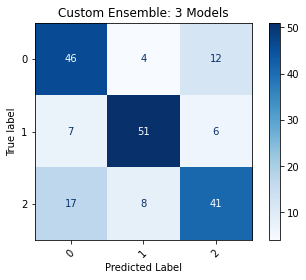

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred)).plot(xticks_rotation=45, cmap=plt.cm.Blues)
disp.ax_.set_title('Custom Ensemble: 3 Models')
disp.ax_.set_xlabel('Predicted Label')
plt.show()

### Results Analysis and Save Models

This ensemble model has an overall accuracy, macro average F1 score, and weighted average F1 score of 72%, showing highly stable predictions across all three classes. It can categorize the potential risk of a project using just the *Title* and *Abstract* as inputs. Three of our five models (the `Logistic Regression` classifier, the `Random Forest Classifier` model, and `the Light Gradient Boosted Classifier` model) contribute to the overall ensemble's performance, resulting in better performance as a whole when compared to each individual part.

To allow NASA to use this ensemble model to categorize the risk of future projects, we will now save each of these models (along with the ensembled model) to the project directory. These will be accessed by the [ClassifyRisk.py](../scripts/classify_risk.py) script. For an example of how to use this script to classify future projects, please take a look at [ClassifyRisk.ipynb](ClassifyRisk.ipynb).

In [44]:
models_dict = {'../models/model_lm.pkl': best_lm,
               '../models/model_rfc.pkl': best_rfc,
               '../models/model_lgb.pkl': best_lgb,
               '../models/model_knn.pkl': best_knn,
               '../models/model_gnb.pkl': best_gnb,
               '../models/model_ensemble.pkl': ensemble_3}

for f_name, model in models_dict.items():
    with open(f_name, 'wb') as f:
        pickle.dump(model, f)

The script will also need the tfidf_vectorizer and pca_vectorizer to preprocess future project descriptions.

In [45]:
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
with open('../models/pca_vectorizer.pkl', 'wb') as f:
    pickle.dump(pca_vectorizer, f)

[Back to Top](#top)